This notebook experiments with artificially darkening images and running them through a semantic segmentation network.

In [1]:
from dataloaders import make_dataset
from dataloaders import custom_transforms as tr
from dataloaders.utils import decode_segmap
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import torch
from PIL import Image

import json
import datetime

from deeplab3.utils import model_utils

font = {'size'   : 16}

matplotlib.rc('font', **font)

In [2]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it. Used for saving figures as GIFs"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

### Set these variables as desired to load different datasets.

In [13]:
dataset_name = 'cityscapes'

#All figures will be saved with the following prefix
figure_prefix = "figures/cityscapes_"

# Dataset directory root
root = '../datasets/cityscapes/'

# Default configuration file
cfg_file = '../configs/cityscapes_rgbd.yaml'

# Load configuration
from deeplab3.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_file)
cfg.merge_from_list(['DATASET.ROOT', root])

Visualize Darkening Effect
----

Load the dataset, fetch and display a sample image

Using RGB-D input
Found 500 val images


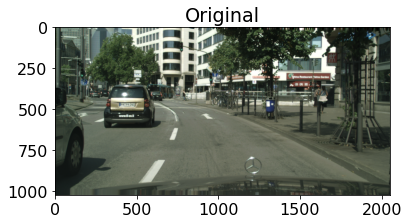

In [27]:
img_idx = 30 # Change this index to get a different image

dataset = make_dataset(cfg, 'val')
img_path, depth_path, label_path = dataset.get_path(img_idx)
sample = dataset.loader.get_sample(img_path, depth_path, label_path)
image = sample['image']

plt.figure()
plt.imshow(image)
plt.title("Original")

crop = image.crop((1500,500, 1550, 550))
crop = crop.resize((500,500), Image.BILINEAR)

image.save('original.png')
crop.save('original_crop.png')

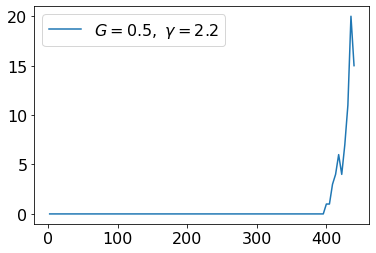

In [38]:
mag = np.sqrt(np.sum(np.power(np.array(image), 2), axis=1))
hist, bins = np.histogram(mag, bins=100, range=(0,442))
#         x = np.linspace(0, 255, 100)
bin_width = bins[1] - bins[0]
x = np.array([x + bin_width/2.0 for x in bins[:-1]])

# hist = hist/n
plt.plot(x, hist, label="$G = {},~\gamma = {}$".format(i, j))
plt.legend()

### Different Darkening Degrees

We artificially manipulate the lighting of the image by changing the gain and gamma correction. The following code displays a grid of images with a range of gain and gamma correction applied to demonstrate the effect. 

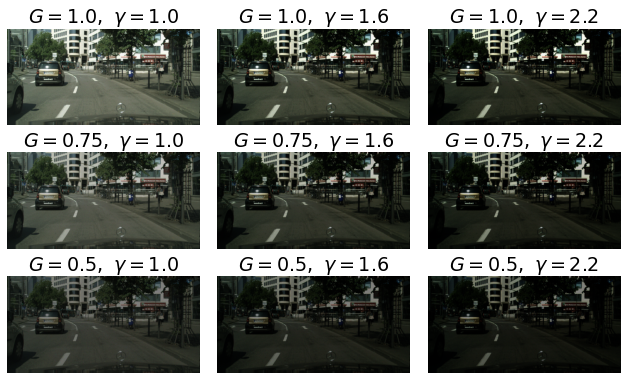

In [18]:
# Change these variables to change the range of applied darkening effect
gain = [1.0, 0.75, 0.5]
gamma = [1.0, 1.6, 2.2]

fig = plt.figure(figsize=(9, 5.5))

dark_imgs = []

index = 1
for i in gain:
    for j in gamma:
        sample['image'] = image.copy()
        
        cfg = get_cfg_defaults()
        cfg.merge_from_file(cfg_file)
        cfg.merge_from_list(['DATASET.ROOT', root])
        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                            'DATASET.DARKEN.GAIN', float(i),
                            'DATASET.DARKEN.GAMMA', float(j)])
        f = tr.Darken(cfg)
        processed_sample = f(sample)
        
        plt.subplot(len(gain), len(gamma), index)
        plt.imshow(processed_sample['image'])
        
        dark_imgs.append(processed_sample['image'])
        
        plt.title("$G = {},~\gamma = {}$".format(i, j))
        plt.axis('off')
        
        index += 1
        
plt.tight_layout()

# Uncomment to save figure 
#fig.savefig(figure_prefix + 'dark_grid.eps', format='eps', dpi=300)

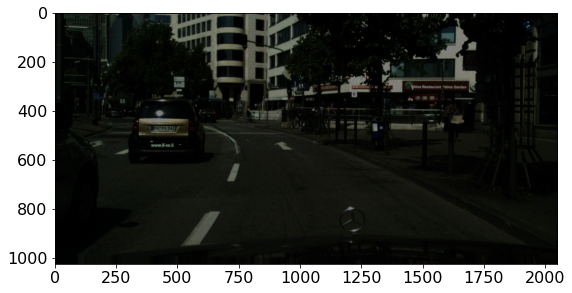

In [22]:
fig = plt.figure(figsize=(9, 5.5))
plt.imshow(processed_sample['image'])
plt.show()

processed_sample['image'].save('darkened.png')

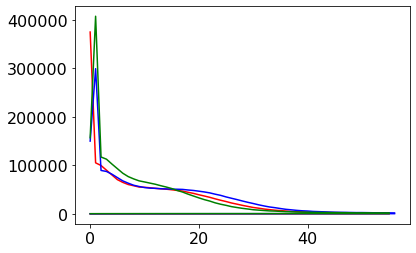

In [35]:
hist = processed_sample['image'].histogram()
plt.plot([(x,hist[x]) for x in range(255) if hist[x]>0], 'r')
plt.plot([(x,hist[x]) for x in range(255, 255*2) if hist[x]>0], 'b')
plt.plot([(x,hist[x]) for x in range(255*2, 255*3) if hist[x]>0], 'g')

In [36]:
hist

[375158,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 105376,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 99858,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 90173,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 80420,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 70747,
 0,
 0,
 0,
 0,
 0,
 0,
 65064,
 0,
 0,
 0,
 0,
 0,
 0,
 60631,
 0,
 0,
 0,
 0,
 0,
 58132,
 0,
 0,
 0,
 0,
 0,
 55468,
 0,
 0,
 0,
 0,
 0,
 54873,
 0,
 0,
 0,
 0,
 53957,
 0,
 0,
 0,
 0,
 52676,
 0,
 0,
 0,
 51803,
 0,
 0,
 0,
 0,
 51014,
 0,
 0,
 0,
 49800,
 0,
 0,
 0,
 48450,
 0,
 0,
 0,
 47092,
 0,
 0,
 0,
 44652,
 0,
 0,
 0,
 42359,
 0,
 0,
 0,
 39522,
 0,
 0,
 36953,
 0,
 0,
 0,
 34242,
 0,
 0,
 31104,
 0,
 0,
 0,
 28175,
 0,
 0,
 25565,
 0,
 0,
 22542,
 0,
 0,
 20165,
 0,
 0,
 17698,
 0,
 0,
 15501,
 0,
 0,
 13312,
 0,
 0,
 11802,
 0,
 0,
 10075,
 0,
 0,
 8808,
 0,
 0,
 7657,
 0,
 6847,
 0,
 0,
 5968,
 0,
 0,
 5160,

### RE-Brightened to visualize noise

In addition to changing the gain and gamma correction, we apply noise to synthesize real noise in low light conditions. In the darkened images, the added noise is hard to see. In the following code, we reverse the gain and gamma correction modifications to make the noise more visible.

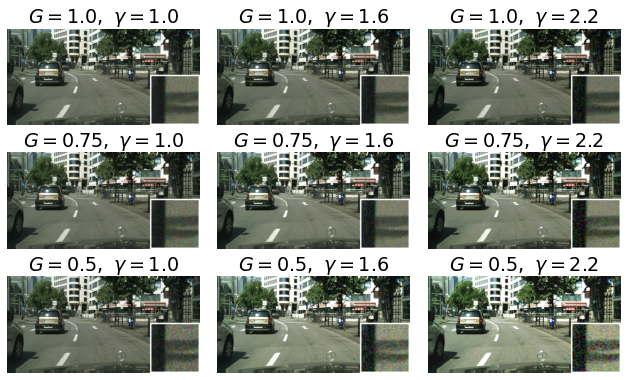

In [23]:
from PIL import Image

fig = plt.figure(figsize=(9, 5.5))

noise_imgs = []

index = 1
for i in gain:
    for j in gamma:
        sample['image'] = image.copy()
        
        cfg = get_cfg_defaults()
        cfg.merge_from_file(cfg_file)
        cfg.merge_from_list(['DATASET.ROOT', root])
        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                            'DATASET.DARKEN.GAIN', float(i),
                            'DATASET.DARKEN.GAMMA', float(j)])
        f = tr.Darken(cfg)
        processed_sample = f(sample)
        
        f = tr.UnDarken(cfg)
        processed_sample = f(processed_sample)
        
        h, w = processed_sample['image'].size
        crop = processed_sample['image'].crop((1500,500, 1550, 550))
        crop = crop.resize((500,500), Image.BILINEAR)
        crop = np.array(crop)
        img = np.array(processed_sample['image'])
        img[w-530:w, h-530:h, :] = 255
        img[w-515:w-15, h-515:h-15, :] = crop
        
        noise_imgs.append(Image.fromarray(img))
        
        plt.subplot(len(gain), len(gamma), index)
        plt.imshow(img)
        plt.title("$G = {},~\gamma = {}$".format(i, j))
        plt.axis('off')
        index += 1
        
plt.tight_layout()

#fig.savefig(figure_prefix + 'noise_grid.eps', format='eps', dpi=300)

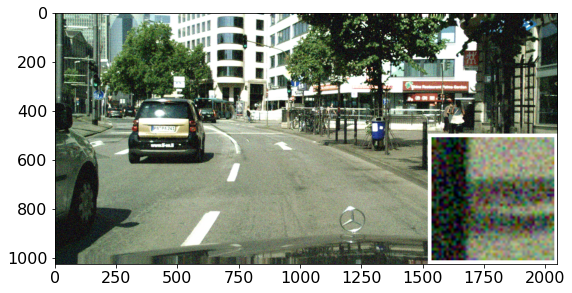

In [26]:
fig = plt.figure(figsize=(9, 5.5))
plt.imshow(img)
plt.show()

Image.fromarray(img).save('brightened.png')
Image.fromarray(crop).save('brightened_crop.png')

### Make Gif
Save the above figures as a GIF

In [7]:
img = noise_imgs[0]
img.save(fp=figure_prefix + 'noise.gif', format='GIF', append_images=noise_imgs[1:],
         save_all=True, duration=1000, loop=0)

img = dark_imgs[0]
img.save(fp=figure_prefix + 'dark.gif', format='GIF', append_images=dark_imgs[1:],
         save_all=True, duration=1000, loop=0)

## Compute Histogram of Darkened Dataset
The darkening algorithm changes the distribution of pixel values. This section generates histograms to visualize these effects.

In [8]:
def sample_distribution(dataset, cfg, n=100, m = 100, channels=4):
    """Samples of m pixels from n images from dataset and calculates summary statistics. Returns dictionary of 
     mean, std, max, median values, and np.array of sampled pixels"""
    n = min(n, len(dataset))

    samples = np.zeros((m*n,channels))
    random_it = np.random.choice(len(dataset), n)
    for it, i in enumerate(random_it):
        img_path, depth_path, label_path = dataset.get_path(i)
        sample = dataset.loader.get_sample(img_path, depth_path, label_path)
        
        f = tr.Darken(cfg)
        sample = tr.ToTensor()(f(sample))
        
        if channels == 4 :
            sample['image'] = torch.cat((sample['image'], sample['depth'].unsqueeze(0)), 0)
        
        if isinstance(sample['image'], list):
            img = [np.asarray(img) for img in sample['image']]
            img = np.concatenate(img, axis=2)
        else:
            img = np.asarray(sample['image'])

        #Flatten image
        img = np.transpose(img, (1,2,0))
        img = np.reshape(img, (img.shape[0]*img.shape[1], img.shape[2]))
        if img.shape[0]>m:
            pixel_i = np.random.choice(img.shape[0], m)
            samples[it*m:(it+1)*m,:] = img[pixel_i, :]

    mean = np.mean(samples, axis=0)
    std = np.std(samples, axis=0)
    m_max = np.max(samples, axis=0)
    median = np.median(samples, axis=0)

    # if dataset.mode == "RGBD":
    #     import matplotlib.pyplot as plt
    #     plt.hist(samples[:, -1], bins='auto')
    #     plt.title("Depth histogram")
    #     plt.show()

    return {'mean': mean, 'std': std, 'max': m_max, 'median':median, 'samples': samples}

In [9]:
def get_dist(cfg_file, root, gain, gamma):
    """Loads dataset specified by cfg_file, manipulates GAIN and GAMMA configuration for each gamma and gain, 
    and calculates summary statistics for each configuration"""
    dist = {i: {j: dict() for j in gamma} for i in gain}

    for i in gain:
        for j in gamma:
            cfg = get_cfg_defaults()
            cfg.merge_from_file(cfg_file)
            cfg.merge_from_list(['DATASET.ROOT', root])
            cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                                'DATASET.DARKEN.GAIN', float(i),
                                'DATASET.DARKEN.GAMMA', float(j)])
            dataset = make_dataset(cfg, 'val')
            dist[i][j] = sample_distribution(dataset, cfg, 100)
    return dist

In [10]:
def plot_dist(dist, gain, gamma, dataset_name=dataset_name):
    """Plots histogram as line graph"""
    fig = plt.figure(figsize=(5, 5))
#     plt.yscale('log')
    plt.ylim([0, 0.1])
    plt.xlim([0, 442])

    for i in gain:
        for j in gamma:
            n = dist[i][j]['samples'].shape[0]
            mag = np.sqrt(np.sum(np.power(dist[i][j]['samples'][:, :3], 2), axis=1))
            hist, bins = np.histogram(mag, bins=100, range=(0,442))
    #         x = np.linspace(0, 255, 100)
            bin_width = bins[1] - bins[0]
            x = np.array([x + bin_width/2.0 for x in bins[:-1]])

            hist = hist/n
            plt.plot(x, hist, label="$G = {},~\gamma = {}$".format(i, j))
#     plt.title('{} RGB Histogram Under Different Darkening Treatments'.format(dataset_name))    
    plt.xlabel('Pixel Magnitude')
    plt.ylabel('Percentage of Pixels'.format(len(dist[i][j]['samples'])))
#     plt.legend()
    
    return fig

In [13]:
# This calculation takes some time. Sit back and do something else while you wait
dist = get_dist(cfg_file, root, gain, gamma)

Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images


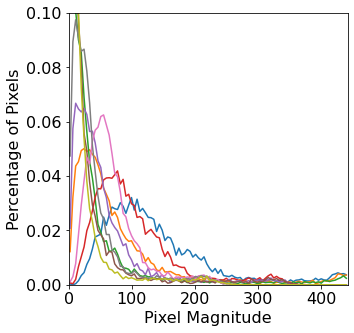

In [14]:
fig = plot_dist(dist, gain, gamma, dataset_name=dataset_name)
fig.savefig(figure_prefix + 'rgb_histogram_small.eps', format='eps')

### Make Gif

In [15]:
def make_hist_gif(cfg_file, root, gain_gamma_pairs):
    """Make GIF of histogram using gain_gamma_pairs configurations. 
    This plots a subset of the plot_dist function making for less busy GIFS"""
    imgs = []
    dist = []
    fig = plt.figure(figsize=(5, 5))
    #     plt.yscale('log')
    plt.ylim([0, 0.1])
    plt.xlim([0, 442])

    plt.xlabel('Pixel Magnitude')
    plt.ylabel('Percentage of Pixels')

    for i,j in gain_gamma_pairs: 
        cfg = get_cfg_defaults()
        cfg.merge_from_file(cfg_file)
        cfg.merge_from_list(['DATASET.ROOT', root])
        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                            'DATASET.DARKEN.GAIN', float(i),
                            'DATASET.DARKEN.GAMMA', float(j)])
        dataset = make_dataset(cfg, 'val')
        dist.append(sample_distribution(dataset, cfg, 100))

        n = dist[-1]['samples'].shape[0]
        mag = np.sqrt(np.sum(np.power(dist[-1]['samples'][:, :3], 2), axis=1))
        hist, bins = np.histogram(mag, bins=100, range=(0,442))
    #         x = np.linspace(0, 255, 100)
        bin_width = bins[1] - bins[0]
        x = np.array([x + bin_width/2.0 for x in bins[:-1]])

        hist = hist/n
        plt.plot(x, hist, label="$G = {},~\gamma = {}$".format(i, j))
        plt.legend()
        
        imgs.append(fig2img(fig))
        
    return imgs

Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images


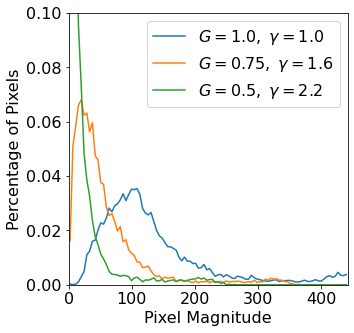

In [17]:
# This calculation takes some time. Sit back and do something else while you wait
img, *imgs = make_hist_gif(cfg_file, root,
                     [(1.0, 1.0), (0.75, 1.6), (0.5, 2.2)])
img.save(fp=figure_prefix +'histogram.gif', format='GIF', append_images=imgs,
         save_all=True, duration=1000, loop=0)

## Network Performance

We train several models with low-light augmentation to test whether RGBD models are more robust in low-light conditions. This following section compares the performance of various trained models.

In [44]:
low_light_models = [ \
                    #Bright models 
                   '../run/cityscapes/cityscapes_rgbd_xception_fine_coarse/2020_08_20-15_58_16/parameters.yaml',
                   '../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/parameters.yaml',
                    '../run/scenenet/scenenet_rgbd_xception/2020_09_17-22_10_19/parameters.yaml',
                   '../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/parameters.yaml',
                    #Low-light augmented models
                   '../run/cityscapes/cityscapes_rgbd_xception_low_light/2020_09_25-19_32_43/parameters.yaml',
                   '../run/cityscapes/cityscapes_rgb_xception_low_light/2020_09_25-19_36_53/parameters.yaml',
                   '../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_25-23_11_51/parameters.yaml',
                   '../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_28-08_36_05/parameters.yaml']

In [ ]:
# Choose range of gain and gamma augmentation for experiments 
gain = [1.0, 0.66, 0.33]
gamma = [1.0, 2.0, 3.0]

In [45]:
def get_metrics(dataset_name, models, cfg_list, report='validation_report.txt'):
    """Runs models matching dataset_name in models list"""
    failed = []

    metric_dict = {'RGB': { 'low-light': 0.0,
                            'normal': 0.0} ,
                   'RGBD' : { 'low-light': 0.0,
                            'normal': 0.0}}

    for index, cfg_filepath in enumerate(models):
        try:
            cfg = model_utils.match_cfg_versions(cfg_filepath)
            if cfg.DATASET.NAME != dataset_name:
                continue
                
            cfg.merge_from_list(['CHECKPOINT.DIRECTORY', os.path.dirname(cfg_filepath),
                                 'TEST.MAX_ITER', 1000,
                                 'MODEL.PRETRAINED', "",
                                 'SYSTEM.GPU_IDS', [0]]) #Since we're using saved models, pretrained weights will be overwritten anyway.
            cfg.merge_from_list(cfg_list)
            
            low = "low-light" if index>3 else "normal"

            model_filepath = os.path.join(cfg.CHECKPOINT.DIRECTORY, cfg.CHECKPOINT.MODEL)
            checkpoint = torch.load(model_filepath, map_location=torch.device('cpu'))

            result_file = os.path.join(cfg.CHECKPOINT.DIRECTORY, report)
            if os.path.exists(result_file):
                with open(result_file, 'r') as fp:
                    metric_str = fp.read().split('{')[1].split('}')[0].replace("'", '"')
                    metrics = json.loads('{' + metric_str + '}')
#                     print("Success on {} : {} ".format(cfg_filepath, metrics['mIoU']))
            else:
                metrics = {'mIoU': 0}
                print("Failed to load {}".format(result_file))
                metrics = model_utils.test_model(cfg, result_file)

            metric_dict[cfg.DATASET.MODE][low] = metrics['mIoU']

        except Exception as e:
            print(e)
            print(cfg_filepath)
            failed.append(cfg_filepath)
            
    return metric_dict

In [46]:
def run_all_models(dataset_name, gain, gamma, models=low_light_models):
    for i in gain:
        for j in gamma:
            cfg_list = ['DATASET.DARKEN.DARKEN', True,
                                'DATASET.DARKEN.GAIN', float(i),
                                'DATASET.DARKEN.GAMMA', float(j)]

            result_file = os.path.join('validation_report_gain{:3.2f}_gamma{:3.2f}.txt'.format(float(i), float(j)))
            metric_dict = get_metrics(dataset_name, models, cfg_list, result_file)

First, run all the models with the desired gain and gamma augmentation on test set and save the results. This may take some time. 

In [47]:
run_all_models(dataset_name, gain, gamma)

Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET


Now, we can visualize the performance differences. First, let's make a bar chart to visualize how mIOU varies with gain and gamma correction augmentation.

In [48]:
from torchvision import transforms

def bar_plot(cfg, img_path, depth_path, label_path, models=low_light_models):
    """Plot a bar plot of the mIoU for different levels of image augmentation"""
    fig = plt.figure(figsize=(12, 12))
    
    font = {'size'   : 14}
    matplotlib.rc('font', **font)
    
    index = 1
    for i in gain:
        for j in gamma:
            cfg_list = ['DATASET.DARKEN.DARKEN', True,
                        'DATASET.DARKEN.GAIN', float(i),
                        'DATASET.DARKEN.GAMMA', float(j)]
            cfg.merge_from_list(cfg_list)
            
            dataset = make_dataset(cfg, 'val')
            sample = dataset.loader.load_sample(img_path, depth_path, label_path)
            sample['image'] = transforms.ToPILImage()(dataset.loader.invert_normalization(sample['image']))
            
            f = tr.UnDarken(cfg)
            sample = f(sample)

            plt.subplot(len(gain)*2, len(gamma)*2, index)
            plt.imshow(sample['image'])
            plt.title("$G = {},~\gamma = {}$".format(i, j))
            plt.axis('off')
            index += 1

            y_pos = np.arange(2)
            width = 0.20

            result_file = os.path.join('validation_report_gain{:3.2f}_gamma{:3.2f}.txt'.format(float(i), float(j)))
            metric_dict = get_metrics(dataset_name, models, cfg_list, result_file)
            
            ax1 = plt.subplot(len(gain)*2, len(gamma)*2, index)
            ax1.bar(-2*width, [metric_dict['RGB']['low-light']],
                    width=width, color='midnightblue', label="rgb low-light")
            ax1.bar(-width, [metric_dict['RGBD']['low-light']] ,
                    width=width, color='darkred', label="rgbd low-light")
            ax1.bar(0, [metric_dict['RGB']['normal']],
                    width=width, color='blue', label="rgb")
            ax1.bar(width, [metric_dict['RGBD']['normal']],
                    width=width, color='red', label="rgbd")

            plt.ylim((0, .6))
            ax1.get_yaxis().set_visible(False)
            ax1.get_xaxis().set_visible(False)

            for p in ax1.patches:
                if p.get_height() > 0 :
                    ax1.annotate("{:.2f}".format(p.get_height()), (p.get_x()+0.05, p.get_height()+0.05), rotation=90)

            index += 1

    ax1.legend()
    
    return fig

Using RGB-D input
Found 500 val images
Using RGB-D input
Found 500 val images
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Using RGB-D input
Found 500 val images
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Using RGB-D input
Found 500 val images
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Using RGB-D input
Found 500 val images
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Using RGB-D input
Found 500 val images
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Using RGB-D input
Found 500 val images
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Using RGB-D input
Found 500 val images
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Using RGB-D input
Found 500 val images
Non-e

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


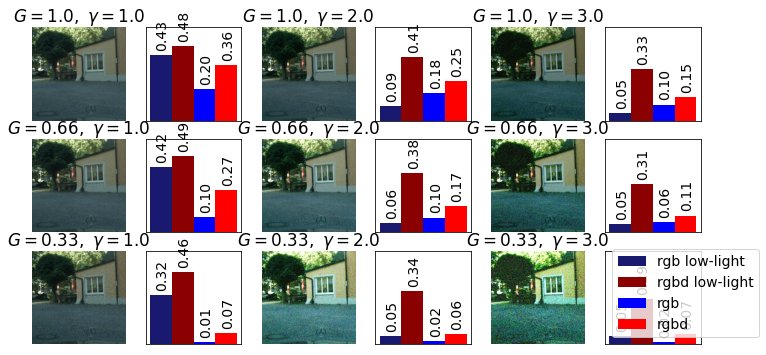

In [50]:
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_file)
cfg.merge_from_list(['DATASET.ROOT', root])

dataset = make_dataset(cfg, 'val')
img_path, depth_path, label_path = dataset.get_path(5)

fig = bar_plot(cfg, img_path, depth_path, label_path)
fig.savefig(figure_prefix + 'result_grid.eps', format='eps', dpi=300)

Next, let's look at the role played by our input channels with an ablation study. 

In [51]:
def grouped_bar_plot(ax1, metrics, labels):
    """Metrics is list of metric_dict. Each element in the list becomes a group of bars with a label from labels"""
    y_pos = np.arange(len(metrics))
    width = 0.2
    
    for i, metric_dict in enumerate(metrics):
        ax1.bar(y_pos[i] - 2*width, [metric_dict['RGB']['low-light']], 
                width=width, color='midnightblue', label='rgb low-light')
        ax1.bar(y_pos[i] - width, [metric_dict['RGBD']['low-light']], 
                width=width, color='darkred', label='rgbd low-light')
        ax1.bar(y_pos[i], [metric_dict['RGB']['normal']], 
                width=width, color='blue', label='rgb')
        ax1.bar(y_pos[i] + width, [metric_dict['RGBD']['normal']],
                width=width, color='red', label='rgbd')

        plt.ylim((0, .7))
        plt.ylabel('mIoU')

    for p in ax1.patches:
        if p.get_height() > 0 :
            ax1.annotate("{:.2f}".format(p.get_height()), (p.get_x() * 1.005+.05, p.get_height() * 1.005+0.05), rotation=90)
    
    ax1.set_xticks(y_pos)
    ax1.set_xticklabels(labels)

Using RGB-D input
Found 500 val images
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


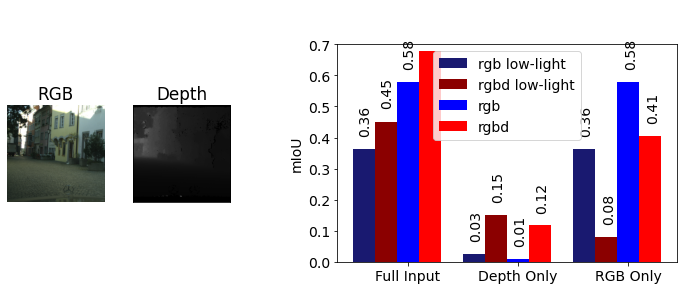

In [52]:
from matplotlib import gridspec

fig = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(1, 4, width_ratios=[2, 2, 1, 7]) 

cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_file)
cfg.merge_from_list(['DATASET.ROOT', root])
cfg_list = ['DATASET.DARKEN.DARKEN', True]

dataset = make_dataset(cfg, 'val')
img_path, depth_path, label_path = dataset.get_path(10)
sample = dataset.loader.load_sample(img_path, depth_path, label_path)
sample['image'] = dataset.loader.invert_normalization(sample['image'])

base_metrics = get_metrics(dataset_name, low_light_models, cfg_list, 'validation_report.txt')
depth_metrics = get_metrics(dataset_name, low_light_models, cfg_list, 'validation_report_depth_only.txt')
rgb_metrics = get_metrics(dataset_name, low_light_models, cfg_list, 'validation_report_no_depth.txt')
metrics = [base_metrics, depth_metrics, rgb_metrics]
labels = ["Full Input", "Depth Only", "RGB Only"]

ax = plt.subplot(gs[0])
plt.title("RGB")
plt.imshow(sample['image'][:, :, :3])
plt.axis('off')

ax = plt.subplot(gs[1])
plt.title("Depth")
plt.imshow(sample['image'][:, :, 3:], cmap=plt.get_cmap('gray'))
# plt.colorbar(fraction=0.046, pad=0.04)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)

ax1 = plt.subplot(gs[3])
grouped_bar_plot(ax1, metrics, labels)
ax1.legend(['rgb low-light', 'rgbd low-light', 'rgb', 'rgbd'])

fig.savefig(figure_prefix +'ablation_study_gray.eps', format='eps')

And finally, let's investigate the role of noise augmentation.

In [59]:
def line_plot(ax, report_template, variable, samples, dataset_name=dataset_name, models=low_light_models):
    """Make line plot of mIOU for different values of variable 
        Parameters: 
            ax - axis for plot
            report_template - format string for report output
            variable - cfg variable that is being investigated
            samples - list of values for variable"""
    rgb_low = []
    rgbd_low = []
    rgb = []
    rgbd = []
    
    for i in samples:
        cfg_list = ['DATASET.DARKEN.DARKEN', True, variable, i]
        metric_dict = get_metrics(dataset_name, models, cfg_list, report_template.format(float(i)))
        
        rgb.append(metric_dict['RGB']['normal'])
        rgbd.append(metric_dict['RGBD']['normal'])
        rgb_low.append(metric_dict['RGB']['low-light'])
        rgbd_low.append(metric_dict['RGBD']['low-light'])

    ax.plot(samples, rgb_low, '.-', color='midnightblue', label='rgb low-light')
    ax.plot(samples, rgbd_low, '.-', color='darkred', label='rgbd low-light')
    ax.plot(samples, rgb, '.-', color='blue', label='rgb')
    ax.plot(samples, rgbd, '.-', color='red', label='rgbd')
    #     return fig

Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Non-existent key: DATASET.CITYSCAP

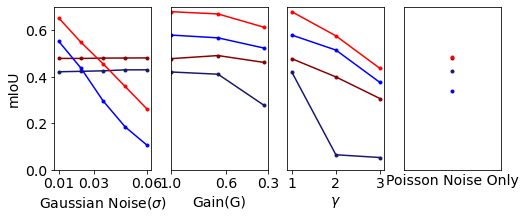

In [60]:
sigma = np.linspace(0.01, 0.06, 5)

fig = plt.figure(figsize=(8, 3))

ax = plt.subplot(1,4,1)
line_plot(ax, 'validation_report_sigma{:f}.txt', 'DATASET.DARKEN.GAUSSIAN_SIGMA', [float(x) for x in sigma])
plt.ylim(0, .7)
ax.set_xticks([0.01, 0.03, 0.06])
# ax.set_xticklabels(labels)
plt.ylabel('mIoU')
plt.xlabel('Gaussian Noise($\sigma$)')

ax = plt.subplot(1,4,2)
line_plot(ax, 'validation_report_gain{:3.2f}_no_noise.txt', 'DATASET.DARKEN.GAIN', gain)
plt.ylim(0, .7)
ax.get_yaxis().set_visible(False)
plt.xlim(1.0, 0.33)
ax.set_xticks([1, 0.6, 0.3])
plt.xlabel('Gain(G)')

ax = plt.subplot(1,4,3)
line_plot(ax, 'validation_report_gamma{:3.2f}_no_noise.txt', 'DATASET.DARKEN.GAMMA', gamma)
plt.ylim(0, .7)
ax.get_yaxis().set_visible(False)
ax.set_xticks([1, 2, 3])
plt.xlabel('$\gamma$')

ax = plt.subplot(1,4,4)
line_plot(ax, 'validation_report_poisson_only.txt', 'DATASET.DARKEN.POISSON', [False])
plt.ylim(0, .7)
ax.get_yaxis().set_visible(False)
ax.set_xticks([])
plt.xlabel('Poisson Noise Only')

plt.legend()

# plt.tight_layout()
fig.savefig('figures/cityscapes_sensitivity_long.eps', format='eps', bbox_inches = "tight")